In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Set SURVEYSIM path

In [2]:
os.environ["SURVEYSIM_PATH"] = "/home/rodrigo/supernovae_detection/surveysim"
sys.path.append("%s/lib" % os.environ["SURVEYSIM_PATH"])

if not os.path.exists("plots"):
    os.makedirs("plots")

Here we load many modules with classes specifically designed for this problem:

- constants: physical constants
- obsplan: observational plans (can be loaded from file)
- LCz: light curve model for different redshifts
- LCz_Av: light curve model for different redshifts and extinctions
- LCz_Av_params: family of light curve models for different redshifts, extinctions and physical parameters
- SFHs: star formation histories
- survey_multimodel: a survey which is a combination of a family of models, a star formation history and an observational plan
- cos_calc: cosmology

In [4]:
from constants import *
from obsplan import *
from LCz import *
from LCz_Av import *
from LCz_Av_params import *
from SFHs import *
from survey_multimodel import *

# Cosmology stuff                                                                                                                                     
import cos_calc

Here we define the family of models, MoriyaWindAcc, which corresponds to wind acceleration models from Moriya et al. 2017, and an observatory, in this CFHT-MegaCam, whose observational plan is contained in SNLS_bands.dat

In [5]:
# filtername                                                                                                                                      
modelname = "MoriyaWindAcc"
obsname = "CFHT-MegaCam"#"Blanco-DECam" #"CFHT-MegaCam" #Blanco-DECam" #"KMTNet"

Here we load the observational plan from the SNLS_bands.dat file and create an object obsplan

Observation plan name: SNLS_bands-nf1-ne1-nr5-nn8855_CFHT-MegaCam_girz
Number of fields to visit: 1, exposure time: 1136.5
Computing moon phase and sky magnitudes for band g
Computing moon phase and sky magnitudes for band i
Computing moon phase and sky magnitudes for band r
Computing moon phase and sky magnitudes for band z
Computing limiting magnitudes for all bands (this may take some time)
Plotting observational plan


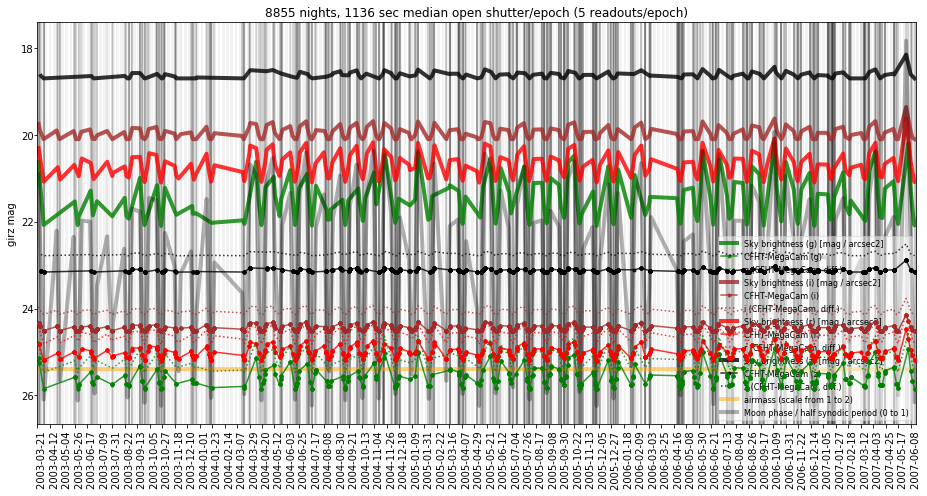

In [6]:
# start an observational plan                                                                                                                     
plan = obsplan(obsname = obsname, mode = 'file-cols', inputfile = "SNLS_bands.dat", nfields = 1, nepochspernight = 1, nightfraction = 0.045, nread = 5, doplot = True, doload = False, bandcolors = {'g': 'g', 'r': 'r', 'i': 'brown', 'z': 'k'})

Here we load the parameters from the family of models from Moriya et al.

**Note that this will be given its own class in the future, e.g. modelgrid**

Note that at this point we only load the file containing the physical parameters and the file names pointing to the time series of spectra associated to each model

In [6]:
# load models                                                                                                                                                                                                   
modelsdir = "%s/models" % os.environ["SURVEYSIM_PATH"]
data = np.genfromtxt("%s/%s/modellist.txt" % (modelsdir, modelname), dtype = str, usecols = (0, 1, 3, 5, 7, 9, 10, 11)).transpose()
data[data == 'no'] = 0
modelfile, modelmsun, modele51, modelmdot, modelrcsm, modelvwind0, modelvwindinf, modelbeta = data
# parameters, specific to MoriyaWindAcc models                                                                                                                                                                  
modelfile = np.array(modelfile, dtype = str)
modelmsun = np.array(modelmsun, dtype = float)
modelfoe = np.array(modele51, dtype = float) / 1e51
modelmdot = np.array(modelmdot, dtype = float)
modelrcsm = np.array(modelrcsm, dtype = float) / 1e15
modelvwind0 = np.array(modelvwind0, dtype = float)  # do not use this                                                                                                                                           
modelvwindinf = np.array(modelvwindinf, dtype = float)
modelbeta = np.array(modelbeta, dtype = float)
params = np.vstack([modelmsun, modelfoe, modelmdot, modelrcsm, modelvwindinf, modelbeta]).transpose()
try:
    files = np.array(list(map(lambda name: "%s.fr" % name, modelfile)))
except:
    files = "%s.fr" % modelf

Here we create grids of redshifts, Avs and times, all log spaced

In [7]:
# Redshift, Avs and time grids                                                                                                                                                                                        
nz = 30
ntimes = 100
nAvs = 10
zs = np.logspace(-3, 0, nz)
times = np.logspace(-3, 3, ntimes)
Avs = np.logspace(-4, 1, nAvs)
Rv = 3

Here we initiliaze the models with the physical parameter names and units, note that we create an object of the class LCz_Av_params

In [8]:
# initialize LCz_Av_params models                                                                                                                                                                               
paramnames = ["mass", "energy", "mdot", "rcsm", "vwindinf", "beta"]
paramunits = ["Msun", "B", "Msun/yr", "1e15 cm", "km/s", ""]
LCs = LCz_Av_params(modelsdir = modelsdir, modelname = modelname, \
                    files = files, paramnames = paramnames, paramunits = paramunits, params = params, \
                    zs = zs, Avs = Avs, Rv = Rv, times = times)

['mass' 'energy' 'mdot' 'rcsm' 'vwindinf' 'beta']


Here we do cosmology at the redshift grid associated to the object LCs

In [9]:
# do cosmology                                                                                                                                                                                                  
LCs.docosmo()

Here we compute the models. This can be VERY slow the first time and may require using a cluster for speed up (load = False, save = True)

In [10]:
# compute models in given bands                                                                                                                                                                                 
if plan.obsname in ["Blanco-DECam"]:
    LCs.compute_models(bands = ['u', 'g', 'r', 'i', 'z'], obsname = obsname, load = True)#, save = True)#, 'r'])#, 'i', 'z'])                                                                                                      
elif plan.obsname in ["KMTNet"]:
    LCs.compute_models(bands = ['g', 'B', 'V', 'R', 'I'], obsname = obsname, load = True)#False, save = True)#, 'r'])#, 'i', 'z'])                                                                                                 
elif plan.obsname in ["CFHT-MegaCam"]:
    LCs.compute_models(bands = ['g', 'r', 'i', 'z'], obsname = obsname, load = True)#False, save = True)#, 'r'])#, 'i', 'z'])                                                                                                 
else:
    print("What bands to use?")

Here we set a metric to be used when interpolating models

In [11]:
# set metric
parammetric = np.array([1., 1., 1e-6, 1., 10., 1.])
paramlogscale = np.array([False, False, True, False, False, True], dtype = bool)
LCs.setmetric(metric = parammetric, logscale = paramlogscale)

Here we associate the observational plan to the object LCs

In [12]:
# set observations                                                                                                                                                                                              
if plan.obsname in ["Blanco-DECam", "CFHT-MegaCam"]:
    LCs.set_observations(mjd = plan.MJDs, flux = None, e_flux = None, filters = plan.bands, objname = None, plot = False, bandcolors = {'g': 'g', 'r': 'r', 'i': 'brown', 'z': 'k'})
elif plan.obsname in ["KMTNet"]:
    LCs.set_observations(mjd = plan.MJDs, flux = None, e_flux = None, filters = plan.bands, objname = None, plot = False, bandcolors = {'g': 'gray', 'B': 'b', 'V': 'g', 'R': 'r', 'I': 'brown'})
else:
    print("What bands to use?")

Here we set a star formation rate and a normalization constant for the star formation rate for these type of events

In [13]:
# star formation                                                                                                                                                                                                
SFH = SFHs(SFH = "MD14")
knorm = 0.0091
IIPfrac = 0.54
efficiency = knorm * IIPfrac

Define the maximum allowed age of an object at the start of the survey (the larger the more computationally expensive the simulations)

In [14]:
# maximum age of object at the start of the survey
maxrestframeage = 3.

Start a new survey!

This combines an observational plan, a star formation history, an efficiency, a LCz_Av_params object and a maximum rest frame age

In [15]:
# start survey                                                                                 
newsurvey = survey_multimodel(obsplan = plan, SFH = SFH, efficiency = efficiency, LCs = LCs, maxrestframeage = maxrestframeage)

Set the maximum redshift for the simulation. The larger the more computationally expensive. This can be done automatically, but can be slow

In [16]:
# set maximum redshift                                                                                                                                                                                          
newsurvey.set_maxz(0.99)

Do cosmology at the redshift grid used for the survey object

In [17]:
# do cosmology with dense grid
newsurvey.do_cosmology()

Set the distribution of physical parameters, as distributions which return distributions of variables defined in rvs and bounds for the same random variables

In [18]:
# set distribution of physical parameters                                                                                                                                                                       
minMJD, maxMJD = min(newsurvey.obsplan.MJDs) - (20. + newsurvey.maxrestframeage) * (1. + max(newsurvey.zs)), max(newsurvey.obsplan.MJDs)
rvs = {'texp': lambda nsim: uniform.rvs(loc = minMJD, scale = maxMJD - minMJD, size = nsim), \
       'logAv': lambda nsim: norm.rvs(loc = np.log(0.1), scale = 1., size = nsim), \
       #'mass': lambda nsim: norm.rvs(loc = 14, scale = 3, size = nsim), \                                                                                                                                      
       'mass': lambda nsim: uniform.rvs(loc = 12., scale = 4., size = nsim), \
       'energy': lambda nsim: norm.rvs(loc = 1., scale = 1., size = nsim), \
       'log10mdot': lambda nsim: uniform.rvs(loc = -8, scale = 6, size = nsim), \
       'beta': lambda nsim: uniform.rvs(loc = 1., scale = 4., size = nsim)}
bounds = {'texp': [minMJD, maxMJD], \
          'logAv': [np.log(1e-4), np.log(10.)], \
          'mass': [12, 16], \
          'energy': [0.5, 2.], \
          'log10mdot': [-8, -2], \
          'beta': [1., 5.]}

Set default physical parameters

In [19]:
# default physical values                                                                                                                                                                                       
mass = None
energy = None
mdot = None
rcsm = 1. # 1e15                                                                                                                                                                                                
vwindinf = 10.
beta = None
pars = np.array([mass, energy, mdot, rcsm, vwindinf, beta]) # must be in same order as paramnames  

Sample events using the previous distributions to generate light curves. 

Note that they are sampled from the expected distribution up to the maximum redshift chosen, which gives very few low redshift SNe (as in nature).

990CPU times: user 36.6 s, sys: 99.3 ms, total: 36.7 s
Wall time: 36.8 s


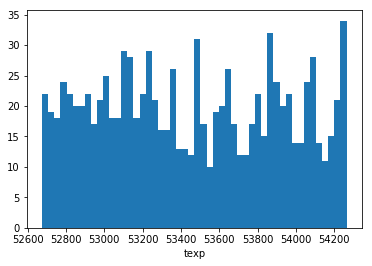

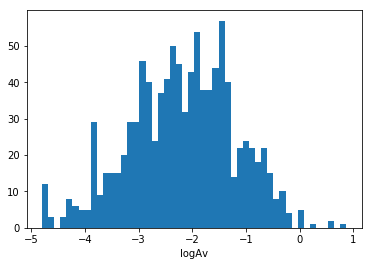

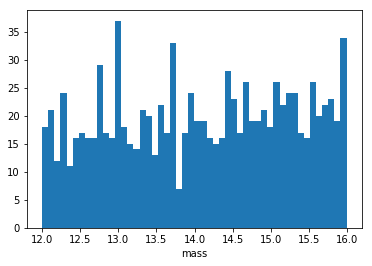

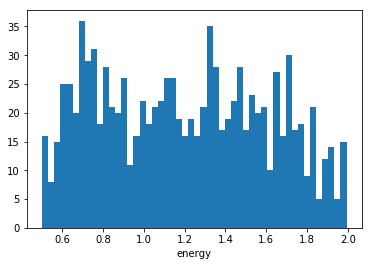

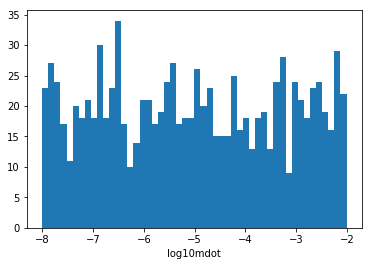

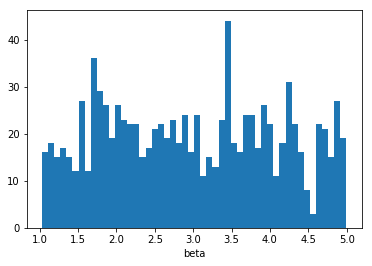

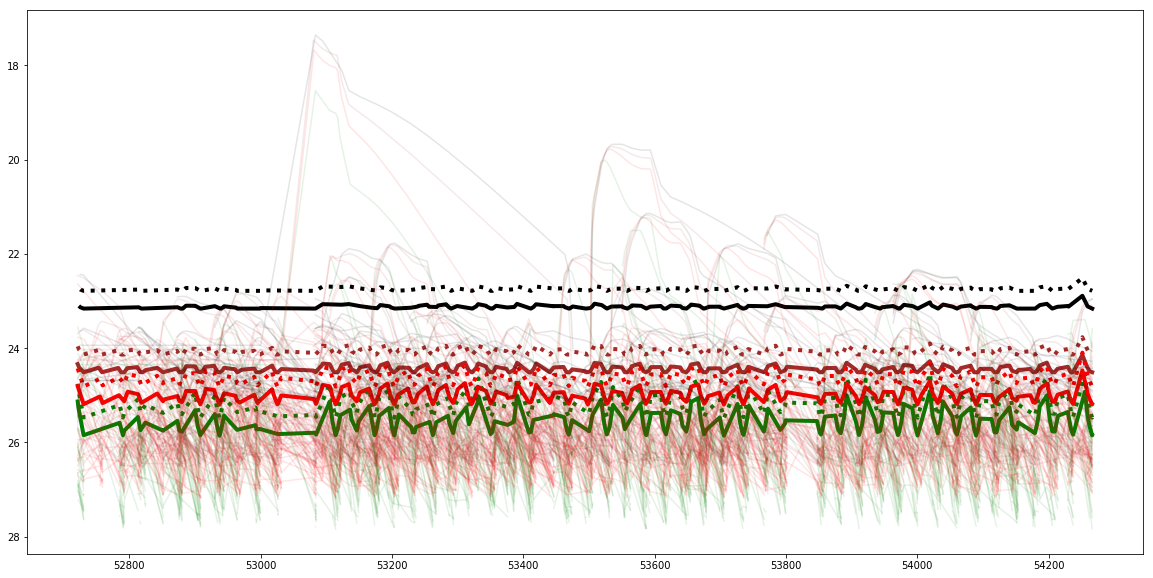

In [20]:
nsim = 1000
%time newsurvey.sample_events(nsim = nsim, doload = False, doplot = True, doemergence = False, \
                              rvs = rvs, bounds = bounds, pars = pars)

Measure the efficiency of detection and the cumulative number of events as a function of redshift and other physical parameters.

This part has many variables hard coded and will need to be generalized

UnboundLocalError: local variable 'tSBO' referenced before assignment

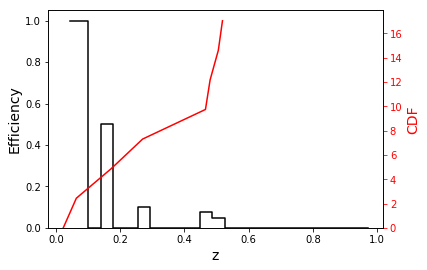

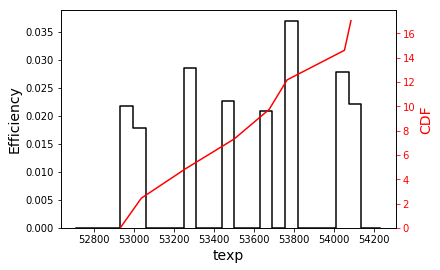

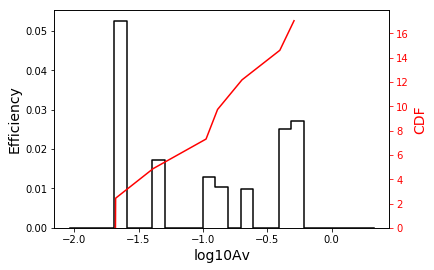

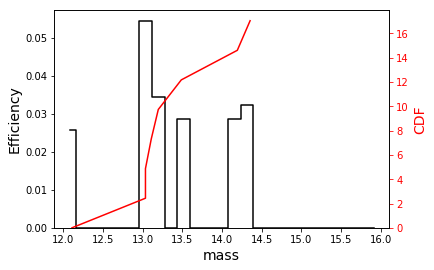

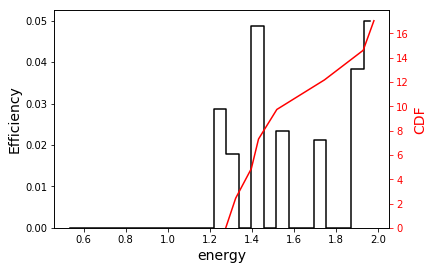

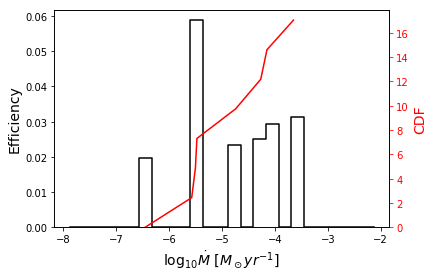

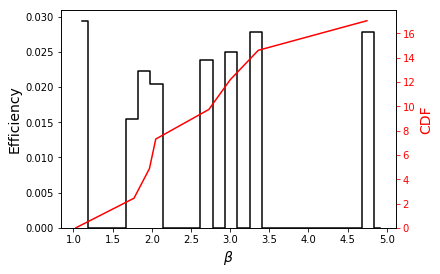

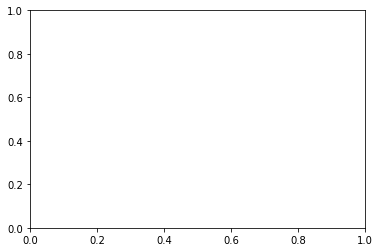

In [21]:
# measure detections and efficiency                                                                                                                                                                             
newsurvey.do_efficiency(doplot = True, verbose = False, check1stdetection = True)